In [199]:
import pickle
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from vrp import VRP
import matplotlib.pyplot as plt
import seaborn as sns

In [200]:
skip_training = True
max_current_iteration = 100

In [201]:
class MetaEnv(gym.Env):
    def __init__(self, vrp):
        self.vrp = vrp

        self.nbin_obj = 30
        self.nbin_F = 20
        self.nbin_it = 3
        self.nA = 3
        self.nS = self.nbin_obj * self.nbin_F * self.nbin_it

        self.obj_bin = np.linspace(20, 40, self.nbin_obj)
        self.F_bin = np.linspace(0, 1, self.nbin_F)
        self.it_bin = np.linspace(0, 200, self.nbin_it).astype(int)

        self.observation_space = spaces.Dict(
            {
                "objective": spaces.Discrete(self.nbin_obj),
                "muation_rate": spaces.Discrete(self.nbin_F),
                "current_iteration": spaces.Discrete(self.nbin_it),
            }
        )

        self.action_space = spaces.Dict(
            {
                "mode": spaces.Discrete(3),
            }
        )

    def _print_bin(self):
        print(self.obj_bin)
        print(self.F_bin)
        print(self.it_bin)

    def _get_obs(self):
        """Convert internal state to observation format.

        Returns:
            dict: Observation
        """
        return {
            "objective": self._cb(
                np.digitize(self.vrp.get_best_solution(), self.obj_bin), self.nbin_obj
            ),
            "mutation_rate": self._cb(np.digitize(self.vrp.F, self.F_bin), self.nbin_F),
            "current_iteration": self._cb(
                np.digitize(self.vrp.current_iteration, self.it_bin), self.nbin_it
            ),
        }

    def _cb(self, idx, nbin):
        # Prevent the out-of-bound idx from np.digitize
        if idx >= nbin:
            return nbin - 1
        else:
            return idx

    def convert_to_flat_index(self, multi_index):
        return np.ravel_multi_index(
            multi_index=multi_index, dims=(self.nbin_obj, self.nbin_F, self.nbin_it)
        )

    def convert_to_multi_index(self, indices):
        return np.unravel_index(
            indices=indices, shape=(self.nbin_obj, self.nbin_F, self.nbin_it)
        )

    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            dict: Info with distance between agent and target
        """
        return {
            "objective": self.vrp.get_best_solution(),
            "mutation_rate": self.vrp.F,
            "current_iteration": self.vrp.current_iteration,
            "delta_F": self.vrp.delta_F,
        }

    def reset(self, seed=None):
        self.vrp.reset()
        super().reset(seed=seed)
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        if action == 1:
            self.vrp.change_F("DECREASE")
        elif action == 2:
            self.vrp.change_F("INCREASE")

        self.vrp.evolve(n_iteration=10)

        reward = -self.vrp.get_best_solution()
        if self.vrp.is_exceed_max_iteration():
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

In [202]:
flat_index = np.ravel_multi_index((1, 1, 1), (10, 10, 10))
flat_index

np.int64(111)

In [203]:
# nbin_obj = 10
# nbin_F = 11
# nbin_it = 1

# obj_bin = np.linspace(20, 40, nbin_obj)
# F_bin = np.linspace(0, 1, nbin_F)
# it_bin = np.linspace(0, 1000, nbin_it).astype(int)

# print(F_bin)
# print(it_bin)
# pi = np.zeros((nbin_obj, nbin_F, nbin_it))

# np.digitize(-1, it_bin)

In [204]:
distance = np.array(
    [
        [0, 0.664, 1.035, 1.789, 4.854, 7.586, 11.425, 11.871],
        [4.857, 0, 0.852, 1.606, 4.671, 7.403, 11.242, 11.688],
        [4.004, 4.23, 0, 0.753, 3.818, 6.55, 10.389, 10.835],
        [5.857, 6.083, 6.454, 0, 3.064, 5.796, 9.635, 10.081],
        [7.267, 7.493, 7.864, 4.066, 0, 2.934, 6.698, 7.144],
        [10.704, 10.93, 11.301, 7.503, 3.68, 0, 5.619, 6.065],
        [13.475, 13.701, 14.072, 10.274, 6.451, 5.409, 0, 0.943],
        [15.079, 15.305, 15.676, 11.878, 8.055, 7.013, 1.603, 0],
    ]
)


dimensions = len(distance) - 1
maxiters = 100
population_size = 100
bounds = np.array([[0, 1]] * dimensions)
Mutation_rate = np.array([0.5, 0.9])
Crossover_rate = np.array([0.1, 0.5])


vrp = VRP(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    distance=distance,
    max_iteration=max_current_iteration,
)

In [205]:
from gymnasium.utils.env_checker import check_env

env = MetaEnv(vrp=vrp)

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment has issues: The first element returned by `env.reset()` is not within the observation space.


In [206]:
env = MetaEnv(vrp=vrp)

print(env.reset())
print(env.action_space.sample())

({'objective': np.int64(19), 'mutation_rate': np.int64(10), 'current_iteration': np.int64(1)}, {'objective': np.float64(32.565), 'mutation_rate': np.float64(0.5), 'current_iteration': 0, 'delta_F': 0.1})
{'mode': np.int64(1)}


In [207]:
env.step(action=2)

({'objective': np.int64(14),
  'mutation_rate': np.int64(12),
  'current_iteration': np.int64(1)},
 np.float64(-29.451),
 False,
 False,
 {'objective': np.float64(29.451),
  'mutation_rate': np.float64(0.6),
  'current_iteration': 10,
  'delta_F': 0.1})

In [208]:
env._print_bin()

[20.         20.68965517 21.37931034 22.06896552 22.75862069 23.44827586
 24.13793103 24.82758621 25.51724138 26.20689655 26.89655172 27.5862069
 28.27586207 28.96551724 29.65517241 30.34482759 31.03448276 31.72413793
 32.4137931  33.10344828 33.79310345 34.48275862 35.17241379 35.86206897
 36.55172414 37.24137931 37.93103448 38.62068966 39.31034483 40.        ]
[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
[  0 100 200]


In [ ]:
# Greedy in the Limit with Infinite Exploration (GLIE)
def GLIE(env, discount_factor=1.0, episode_count=100):
    """
    Find optimal policy given an environment.

    Args:
        env: OpenAI env. In model free setup you have no access to env.P,
             transition dynamics of the environment.
             use step(a) to take an action and receive a tuple
             of (s', r, done, info)
             env.nS is number of states in the environment.
             env.nA is number of actions in the environment.
        episode_count: Number of episodes:
        discount_factor: Gamma discount factor.

    Returns:
        Vector of length env.nS representing the value function.
        policy:[S, A] shaped matrix representing the policy. Random in our case

    """
    # Start with (all 0) state value array and state-action matrix.
    # also initialize visit count to zero for the state-action visit count.
    V = np.zeros(env.nS)
    N = np.zeros((env.nS, env.nA))
    Q = np.zeros((env.nS, env.nA))
    # random policy
    policy = [np.random.randint(env.nA) for _ in range(env.nS)]
    k = 1
    eps = 1

    def argmax_a(arr):
        """
        Return idx of max element in an array.
        Break ties uniformly.
        """
        max_idx = []
        max_val = float("-inf")
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return np.random.choice(max_idx)

    def get_action(state):
        if np.random.random() < eps:
            return np.random.choice(env.nA)
        else:
            return argmax_a(Q[state])

    # run multiple episodes
    while k <= episode_count:
        print(f"k={k}")
        # collect samples for one episode
        episode_states = []
        episode_actions = []
        episode_returns = []
        _state, _ = env.reset()
        state = env.convert_to_flat_index(
            (
                _state["objective"],
                _state["mutation_rate"],
                _state["current_iteration"],
            )
        )
        episode_states.append(state)
        while True:
            action = get_action(state)
            episode_actions.append(action)
            (_state, reward, done, _, info) = env.step(action)
            # print(info)
            state = env.convert_to_flat_index(
                (
                    _state["objective"],
                    _state["mutation_rate"],
                    _state["current_iteration"],
                )
            )
            episode_returns.append(reward)
            if not done:
                episode_states.append(state)
            else:
                break

        # update state-action values
        G = 0
        count = len(episode_states)
        for t in range(count - 1, -1, -1):
            s, a, r = episode_states[t], episode_actions[t], episode_returns[t]
            G = discount_factor * G + r
            N[s, a] += 1
            Q[s, a] = Q[s, a] + 1 / N[s, a] * (G - Q[s, a])

        # Update policy and optimal value
        k = k + 1
        eps = 1 / k
        # uncomment "if" to have higher exploration initially and
        # then let epislon decay after 5000 episodes
        # if k <=100:
        #    eps = 0.02

        for s in range(env.nS):
            best_action = argmax_a(Q[s])
            policy[s] = best_action
            V[s] = Q[s, best_action]

    return np.array(V), np.array(policy)

In [ ]:
if not skip_training:
    # run mc policy control GLIE
    V_pi, policy = GLIE(env, discount_factor=1.0, episode_count=200)

    action_labels = {0: "NO", 1: "REDUCE", 2: "INCREASE"}
    # print policy
    optimal_actions = [action_labels[policy[s]] for s in range(env.nS)]

    with open("pi_star_100.pkl", "wb") as file:
        pickle.dump(
            dict(policy=policy, V_pi=V_pi, optimal_actions=optimal_actions), file
        )

else:
    with open("pi_star_100.pkl", "rb") as file:
        data = pickle.load(file)
        policy = data["policy"]
        V_pi = data["V_pi"]
        optimal_actions = data["optimal_actions"]


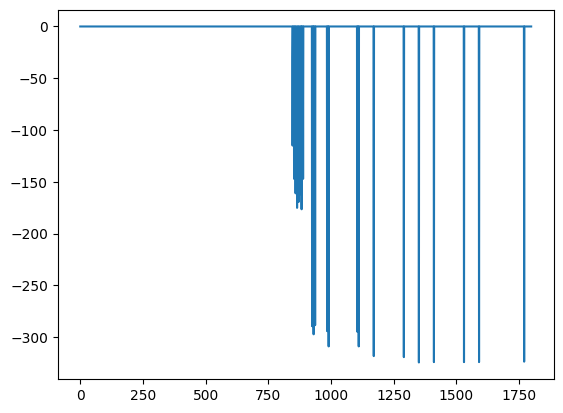

In [211]:
plt.plot(V_pi)

<Axes: xlabel='count'>

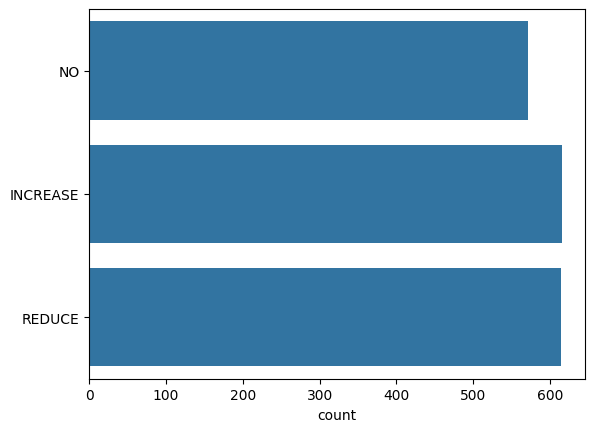

In [212]:
sns.countplot(optimal_actions)

In [213]:
np.random.randint(3)

1

In [218]:
total_reward = 0.0
total_steps = 0
curState, _ = env.reset()

done = False
while not done:
    action = np.random.randint(3)
    curState, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    total_steps += 1
    done = terminated or truncated
    print(
        f"Step {total_steps:2d}: action={action:2d}, Reward={reward:5.2f}, "
        f"Terminated={terminated}, Truncated={truncated}, info={info}"
    )

print(
    f"Episode finished after {total_steps} steps with total reward: {total_reward:.2f}"
)

env.close()

Step  1: action= 0, Reward=-30.81, Terminated=False, Truncated=False, info={'objective': np.float64(30.807), 'mutation_rate': np.float64(0.5), 'current_iteration': 10, 'delta_F': 0.1}
Step  2: action= 0, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.5), 'current_iteration': 20, 'delta_F': 0.1}
Step  3: action= 1, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.4), 'current_iteration': 30, 'delta_F': 0.1}
Step  4: action= 1, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.30000000000000004), 'current_iteration': 40, 'delta_F': 0.1}
Step  5: action= 2, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.4), 'current_iteration': 50, 'delta_F': 0.1}
Step  6: action= 1, Reward=-29.41, Terminated=False, Truncated=False

In [ ]:
total_reward = 0.0
total_steps = 0
curState, _ = env.reset()
state = env.convert_to_flat_index(
    (
        curState["objective"],
        curState["mutation_rate"],
        curState["current_iteration"],
    )
)

done = False
while not done:
    action = policy[state]
    curState, reward, terminated, truncated, info = env.step(action)
    state = env.convert_to_flat_index(
        (
            curState["objective"],
            curState["mutation_rate"],
            curState["current_iteration"],
        )
    )

    total_reward += reward
    total_steps += 1
    done = terminated or truncated
    print(
        f"Step {total_steps:2d}: action={action:2d}, Reward={reward:5.2f}, "
        f"Terminated={terminated}, Truncated={truncated}, info={info}"
    )

print(
    f"Episode finished after {total_steps} steps with total reward: {total_reward:.2f}"
)

env.close()

Step  1: action= 2, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.6), 'current_iteration': 10, 'delta_F': 0.1}
Step  2: action= 0, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.6), 'current_iteration': 20, 'delta_F': 0.1}
Step  3: action= 0, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.6), 'current_iteration': 30, 'delta_F': 0.1}
Step  4: action= 0, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.6), 'current_iteration': 40, 'delta_F': 0.1}
Step  5: action= 0, Reward=-29.41, Terminated=False, Truncated=False, info={'objective': np.float64(29.41), 'mutation_rate': np.float64(0.6), 'current_iteration': 50, 'delta_F': 0.1}
Step  6: action= 0, Reward=-29.41, Terminated=False, Truncated=False, info={'objectiv